# Rain Prediction using Logistic Regression and K-NN

<h2>Introduction</h2>

In [190]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, classification_report
import statsmodels.api as sm
%matplotlib inline
import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [191]:
data = pd.read_csv('data_input/weatherAUS.csv')

In [192]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.400,22.900,0.600,nan,nan,W,44.000,W,...,22.000,1007.700,1007.100,8.000,nan,16.900,21.800,No,0.000,No
1,2008-12-02,Albury,7.400,25.100,0.000,nan,nan,WNW,44.000,NNW,...,25.000,1010.600,1007.800,nan,nan,17.200,24.300,No,0.000,No
2,2008-12-03,Albury,12.900,25.700,0.000,nan,nan,WSW,46.000,W,...,30.000,1007.600,1008.700,nan,2.000,21.000,23.200,No,0.000,No
3,2008-12-04,Albury,9.200,28.000,0.000,nan,nan,NE,24.000,SE,...,16.000,1017.600,1012.800,nan,nan,18.100,26.500,No,1.000,No
4,2008-12-05,Albury,17.500,32.300,1.000,nan,nan,W,41.000,ENE,...,33.000,1010.800,1006.000,7.000,8.000,17.800,29.700,No,0.200,No


In [193]:
data.shape

(142193, 24)

In [194]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

<h4>Drop RISK_MM</h4>

In [195]:
data.drop(['Location','RISK_MM','Date'], axis=1, inplace=True)

<h4>Change date data types</h4>

In [196]:
#data['Date'] = data['Date'].astype('datetime64')

<h3>Working with Categorical Data</h3>

<h4>Fill missing value in categorical data with wording 'unknown'</h4>

In [197]:
data[['WindGustDir','WindDir9am','WindDir3pm','RainToday']] = \
data[['WindGustDir','WindDir9am','WindDir3pm','RainToday']].fillna('unknown')

<h4>Change Data Types</h4>

In [198]:
data[['WindGustDir','WindDir9am','WindDir3pm','RainToday','RainTomorrow']] = \
data[['WindGustDir','WindDir9am','WindDir3pm','RainToday','RainTomorrow']].astype('category')

<h4>Check categorical level</h4>

In [199]:
categorical = data[['WindGustDir','WindDir9am','WindDir3pm','RainToday','RainTomorrow']]

In [200]:
for var in categorical:
    print(var,'contains',len(data[var].unique()), ' labels')

WindGustDir contains 17  labels
WindDir9am contains 17  labels
WindDir3pm contains 17  labels
RainToday contains 3  labels
RainTomorrow contains 2  labels


<h3>Working with Numerical Data</h3>

In [201]:
numerical = data.select_dtypes(include='number')

In [202]:
numerical.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,141556.000,141871.000,140787.000,81350.000,74377.000,132923.000,140845.000,139563.000,140419.000,138583.000,128179.000,128212.000,88536.000,85099.000,141289.000,139467.000
mean,12.186,23.227,2.350,5.470,7.625,39.984,14.002,18.638,68.844,51.483,1017.654,1015.258,4.437,4.503,16.988,21.687
std,6.403,7.118,8.465,4.189,3.782,13.589,8.893,8.803,19.051,20.798,7.105,7.037,2.887,2.721,6.493,6.938
min,-8.500,-4.800,0.000,0.000,0.000,6.000,0.000,0.000,0.000,0.000,980.500,977.100,0.000,0.000,-7.200,-5.400
25%,7.600,17.900,0.000,2.600,4.900,31.000,7.000,13.000,57.000,37.000,1012.900,1010.400,1.000,2.000,12.300,16.600
50%,12.000,22.600,0.000,4.800,8.500,39.000,13.000,19.000,70.000,52.000,1017.600,1015.200,5.000,5.000,16.700,21.100
75%,16.800,28.200,0.800,7.400,10.600,48.000,19.000,24.000,83.000,66.000,1022.400,1020.000,7.000,7.000,21.600,26.400
max,33.900,48.100,371.000,145.000,14.500,135.000,130.000,87.000,100.000,100.000,1041.000,1039.600,9.000,9.000,40.200,46.700


In [203]:
numerical.isna().sum()/len(data)

MinTemp         0.004
MaxTemp         0.002
Rainfall        0.010
Evaporation     0.428
Sunshine        0.477
WindGustSpeed   0.065
WindSpeed9am    0.009
WindSpeed3pm    0.018
Humidity9am     0.012
Humidity3pm     0.025
Pressure9am     0.099
Pressure3pm     0.098
Cloud9am        0.377
Cloud3pm        0.402
Temp9am         0.006
Temp3pm         0.019
dtype: float64

<h4>Delete columns which contains missing value about 40% from data length </h4>

In [204]:
data.drop(['Evaporation','Sunshine','Cloud3pm'], axis=1, inplace=True)

Text(0.5, 1.0, '')

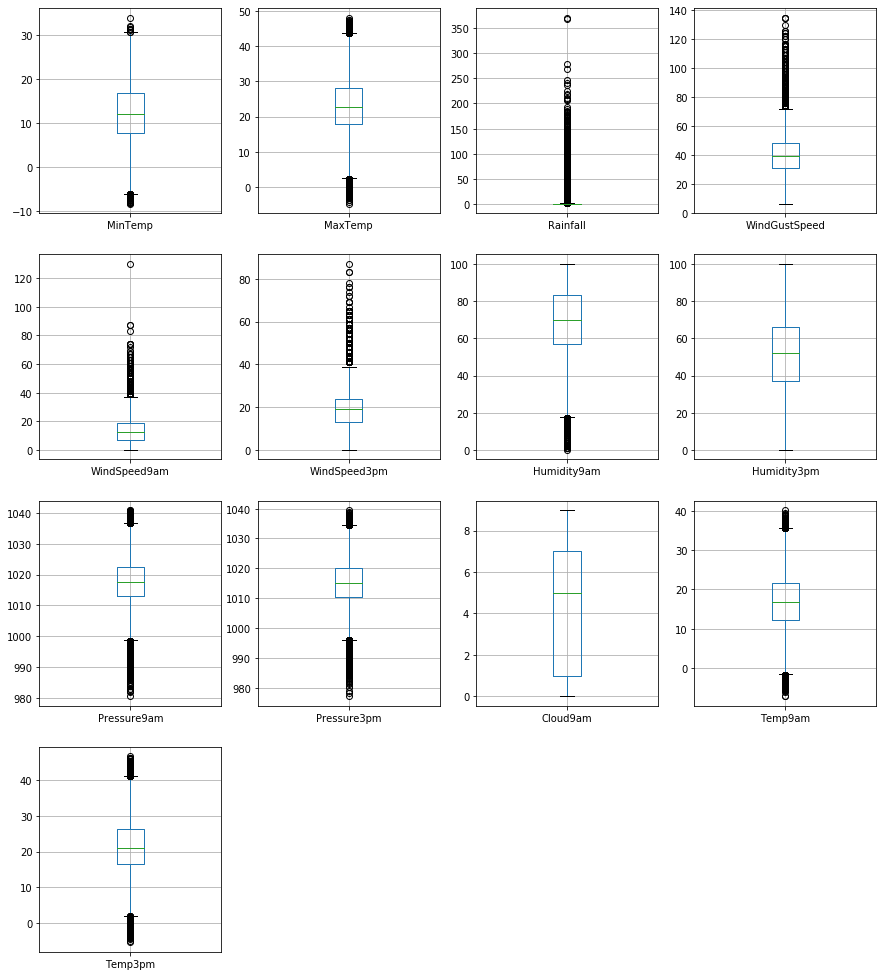

In [205]:
plt.figure(figsize=(15,40))

plt.subplot(9, 4, 1)
fig = data.boxplot(column='MinTemp')
fig.set_title('')

plt.subplot(9, 4, 2)
fig = data.boxplot(column='MaxTemp')
fig.set_title('')

plt.subplot(9, 4, 3)
fig = data.boxplot(column='Rainfall')
fig.set_title('')

plt.subplot(9, 4, 4)
fig = data.boxplot(column='WindGustSpeed')
fig.set_title('')

plt.subplot(9, 4, 5)
fig = data.boxplot(column='WindSpeed9am')
fig.set_title('')

plt.subplot(9, 4, 6)
fig = data.boxplot(column='WindSpeed3pm')
fig.set_title('')

plt.subplot(9, 4, 7)
fig = data.boxplot(column='Humidity9am')
fig.set_title('')

plt.subplot(9, 4, 8)
fig = data.boxplot(column='Humidity3pm')
fig.set_title('')

plt.subplot(9, 4, 9)
fig = data.boxplot(column='Pressure9am')
fig.set_title('')

plt.subplot(9, 4, 10)
fig = data.boxplot(column='Pressure3pm')
fig.set_title('')

plt.subplot(9, 4, 11)
fig = data.boxplot(column='Cloud9am')
fig.set_title('')

plt.subplot(9, 4, 12)
fig = data.boxplot(column='Temp9am')
fig.set_title('')

plt.subplot(9, 4, 13)
fig = data.boxplot(column='Temp3pm')
fig.set_title('')

<h4>Impute missing value</h4>

In [206]:
med_ = data[['MinTemp','MaxTemp','Rainfall','WindGustSpeed','WindSpeed9am','WindSpeed3pm','Humidity9am','Pressure9am',\
             'Pressure3pm','Temp9am','Temp3pm']]
men_ = data[['Humidity3pm','Cloud9am']]

In [207]:
for col in med_:
    col_median=data[col].median()
    data[col].fillna(col_median, inplace=True)
for col_ in men_:
    col_mean=data[col_].mean()
    data[col_].fillna(col_mean,inplace=True)

<h4>Remove outliers</h4>

In [208]:
Q1 = numerical.quantile(0.25)
Q3 = numerical.quantile(0.75)
IQR = Q3 - Q1

In [209]:
#count of outliers
((numerical < (Q1 - 1.5 * IQR)) | (numerical > (Q3 + 1.5 * IQR))).sum()

MinTemp             62
MaxTemp            459
Rainfall         25228
Evaporation       1954
Sunshine             0
WindGustSpeed     3006
WindSpeed9am      1739
WindSpeed3pm      2458
Humidity9am       1419
Humidity3pm          0
Pressure9am       1174
Pressure3pm        906
Cloud9am             0
Cloud3pm             0
Temp9am            247
Temp3pm            735
dtype: int64

In [210]:
data = data[~((numerical < (Q1 - 1.5 * IQR)) |(numerical > (Q3 + 1.5 * IQR))).any(axis=1)]
data.shape

(109459, 18)

<h2>Exploratory Data Analysis</h2>

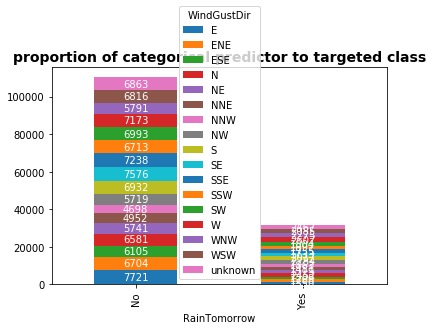

In [211]:
def plotProportion(data):
    ax = categorical.groupby(['RainTomorrow', 'WindGustDir']).size().unstack().plot(kind='bar', stacked=True)
    for rect in ax.patches:
        height = rect.get_height()
        width = rect.get_width()
        padding = 0.25

        ax.text(rect.get_x() + width - padding, 
                rect.get_y() + height / 2, 
                int(height), 
                ha = 'center', va = 'center',
                color = "white")

plotProportion(categorical)
plt.title("proportion of categorical predictor to targeted class", fontsize = 14, fontweight = "bold")
plt.show()

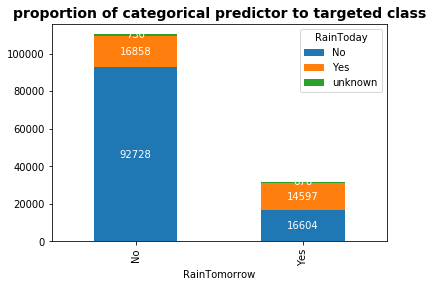

In [212]:
def plotProportion(data):
    ax = categorical.groupby(['RainTomorrow', 'RainToday']).size().unstack().plot(kind='bar', stacked=True)
    for rect in ax.patches:
        height = rect.get_height()
        width = rect.get_width()
        padding = 0.25

        ax.text(rect.get_x() + width - padding, 
                rect.get_y() + height / 2, 
                int(height), 
                ha = 'center', va = 'center',
                color = "white")

plotProportion(categorical)
plt.title("proportion of categorical predictor to targeted class", fontsize = 14, fontweight = "bold")
plt.show()

Rain 16.0 %
No Rain 84.0 %


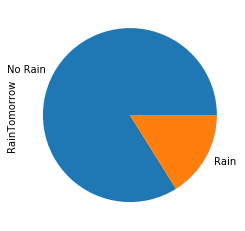

In [213]:
data['RainTomorrow'].value_counts().plot(kind = 'pie', labels = [ 'No Rain','Rain'])
print('Rain', round(data['RainTomorrow'].value_counts()['Yes']/len(data) * 100), '%')
print('No Rain', round(data['RainTomorrow'].value_counts()['No']/len(data) * 100), '%')

<h2>Modelling</h2>

<h2>A. Logistic Regression</h2>

In [214]:
cat_columns = data.select_dtypes(['category']).columns
data_new = pd.get_dummies(data, columns = cat_columns, drop_first = True)

In [215]:
data_new.head(2)

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,...,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_unknown,RainToday_Yes,RainToday_unknown,RainTomorrow_Yes
0,13.400,22.900,0.600,44.000,20.000,24.000,71.000,22.000,1007.700,1007.100,...,0,0,0,0,1,0,0,0,0,0
1,7.400,25.100,0.000,44.000,4.000,22.000,44.000,25.000,1010.600,1007.800,...,0,0,0,0,0,1,0,0,0,0


In [216]:
#separate predictor and target
X = data_new.drop('RainTomorrow_Yes', axis=1)
y = data_new.RainTomorrow_Yes.values

#setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train:",X_train.shape)
print("X_test:",X_test.shape)
print("y_train:",y_train.shape)
print("y_test:",y_test.shape)

X_train: (87567, 63)
X_test: (21892, 63)
y_train: (87567,)
y_test: (21892,)


In [217]:
lr = LogisticRegression(multi_class='ovr',solver='liblinear').fit(X_train, y_train)
lr_pred = lr.predict(X_test)

In [221]:
print(accuracy_score(y_test_up, lr_pred_up))

Classification accuracy : 0.8617


<h3>Feature Engineering</h3>

<h4>Upsampling Process</h4>

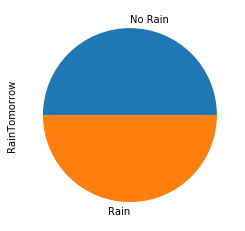

In [222]:
#doing upsampling
from sklearn.utils import resample

rain = data[data.RainTomorrow == 'Yes']
no_rain = data[data.RainTomorrow == 'No']

rain_upsampling = resample(rain, replace=True, n_samples = len(no_rain), random_state = 42)
rain_upsampling = pd.concat([no_rain,rain_upsampling])
rain_upsampling['RainTomorrow'].value_counts()
rain_upsampling['RainTomorrow'].value_counts().plot(kind = 'pie', labels = [ 'No Rain','Rain'])

In [223]:
cat_columns = rain_upsampling.select_dtypes(['category']).columns
data_up = pd.get_dummies(rain_upsampling, columns = cat_columns, drop_first = True)

In [224]:
#separate predictor and target
X_up = data_up.drop('RainTomorrow_Yes', axis=1)
y_up = data_up.RainTomorrow_Yes.values

#setting up testing and training sets
X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(X_up, y_up, test_size=0.2, random_state=42)
print("X_train:",X_train_up.shape)
print("X_test:",X_test_up.shape)
print("y_train:",y_train_up.shape)
print("y_test:",y_test_up.shape)

X_train: (146923, 63)
X_test: (36731, 63)
y_train: (146923,)
y_test: (36731,)


In [225]:
lr_up = LogisticRegression(multi_class='ovr',solver='liblinear').fit(X_train_up, y_train_up)
lr_pred_up = lr_up.predict(X_test_up)

In [226]:
print(accuracy_score(y_test_up, lr_pred_up))

0.7560643598050693


<h2>B. K-NN</h2>

In [229]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), index=X.index, columns=X.columns)

In [231]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5)
classifier.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [232]:
knn_pred = classifier.predict(X_test)


In [233]:
score = accuracy_score(y_test,knn_pred)
print('Accuracy :',score)

Accuracy : 0.8532340581034168


<h2>ROC-AUC</h2>

<h3>Logistic Regression</h3>

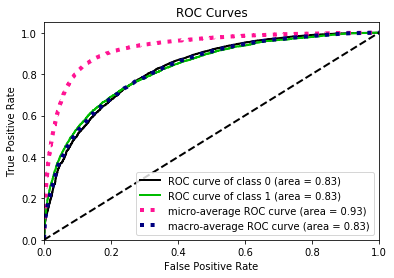

In [234]:
import scikitplot as skplt
skplt.metrics.plot_roc(y_test, lr.predict_proba(X_test)) 

<h3>K-NN</h3>

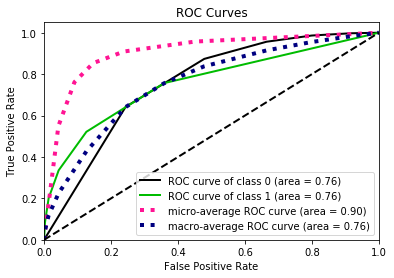

In [235]:
skplt.metrics.plot_roc(y_test, classifier.predict_proba(X_test)) 

<h2>Recall and Precision</h2>

<h3>Logistic Regression</h3>

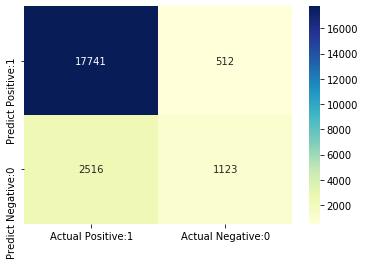

In [236]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, lr_pred)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')


In [237]:
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

In [238]:
# print precision score

precision = TP / float(TP + FP)


print('Precision : {}'.format(precision))

Precision : 0.9719498164685257


In [239]:
recall = TP / float(TP + FN)

print('Recall or Sensitivity : {}'.format(recall))

Recall or Sensitivity : 0.8757960211284987


<h3>K-NN</h3>

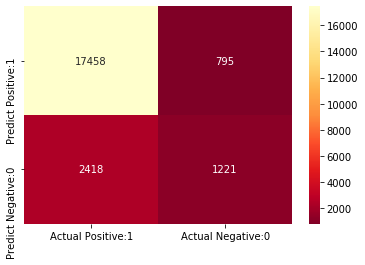

In [240]:
cm_knn = confusion_matrix(y_test, knn_pred)

cm_matrix_knn = pd.DataFrame(data=cm_knn, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix_knn, annot=True, fmt='d', cmap='YlOrRd_r')

In [241]:
TP_KNN = cm_knn[0,0]
TN_KNN = cm_knn[1,1]
FP_KNN = cm_knn[0,1]
FN_KNN = cm_knn[1,0]

In [242]:
# print precision score

precision_knn = TP_KNN / float(TP_KNN + FP_KNN)


print('Precision : {}'.format(precision_knn))

Precision : 0.956445515805621


In [243]:
recall_knn = TP_KNN / float(TP_KNN + FN_KNN)

print('Recall or Sensitivity : {}'.format(recall_knn))

Recall or Sensitivity : 0.8783457436103844


<h2>Conclusion</h2>